Финальный проект по курсу "Нейронные сети"
---

**Требования к курсовому проекту**:

Оформить ноутбук со следующими этапами:

1. Знакомство с данными (визуализация, вывод примеров, меток классов/значений целевой переменной)
2. Предобработка (нормализация, оформление генератора, аугментации)
3. Эксперименты с моделями
4. Валидация модели
5. Инференс модели (работа модели на тестовых объектах, если это соревнование - генерация csv для сабмита)
6. Выводы по работе (интерпретация результатов, что можно ещё поделать, чего не хватило, планы на будущее)

# 1. Знакомство с данными

Для финального проекта выбран набор данных по флюорографии (рентген лёгких): https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels

Датасет содержит:
- изображения рентгеновских снимков (80 здоровых и 58 с туберкулёзом), 
- маски,
- текстовые описания к каждому объекту (пол, возраст и дагноз):

Формат изображений: PNG, 4020x4892 или 4892x4020, 12 бит.

# Загрузка необходимых библиотек и функций

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import PIL
import re
from tqdm import tqdm
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras
import keras.backend as K
from keras import backend as keras

import cv2

### U-net 
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import (Input, Dense, Dropout, Activation, Flatten, Convolution2D, 
                          MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate)
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.activations import *

In [14]:
def test_on_image(model, img_array, img_num, img_side_size = 128):
    
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(1,4,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Predict")
    plt.axis("off")
    
    plt.subplot(1,4,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
    plt.title("Real mask");
    plt.axis("off")
    
    plt.subplot(1,4,3)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "Blues", alpha = 0.5)
    plt.imshow(pred.reshape(img_side_size, img_side_size),cmap = "PuBu", alpha = 0.3)
    plt.title("Overlay")
    plt.axis("off")
    
    plt.subplot(1,4,4)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    plt.title("Original")
    plt.axis("off")
    
    return pred

# dice коэффициент
# функции нужно писать не на Numpy, а на бекэнде, на котором запущен keras, в данном случае на TensorFlow
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

def dice_coef_test(y_true, y_pred):
    # 
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
# построение графиков лосса и дайс коэффицента вв процессе обучения
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Dice coefficient")

# Загрузка, обработка и визуализация данных

In [4]:
DIR = "/kaggle/input/chest-xray-masks-and-labels/data/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png"))

related_paths = defaultdict(list)

for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)

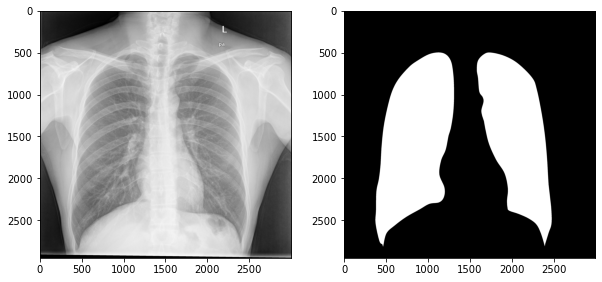

In [5]:
xray_num = 1
img_path = paths_df["image_path"][xray_num]
mask_path = paths_df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray");

Предобработка данных

In [6]:
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 704/704 [00:48<00:00, 14.58it/s]


In [7]:
# разбиваем на трейн и тест
img_train, img_test, mask_train, mask_test = train_test_split(img_array, 
                                                              mask_array, 
                                                              test_size = 0.2, 
                                                              random_state= 42)
img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

# 3. Эксперименты с моделями

Для начала возмём нейронную сеть Unet с курса обучения

In [8]:
def u_net(input_shape=(256, 256, 1)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # в Unet основной посыл в том, чтобы прокидывать признаки в конец сетки,
    # когда уже идёт предсказание маски. Поэтому мы запоминаем этот слой и прокидываем его в конец
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)


    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # начинаем растягивать картинку
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # конкатенируем то что получили после 3-го увеличения и блок 3
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор (14 классов, поэтому softmax)
    x = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    return model

In [15]:
model_1 = u_net(input_shape=(256,256,1))
model_1.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=[dice_coef, 'binary_accuracy'])
model_1.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 256, 256, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 256, 256, 64) 0           batch_normalization_38[0][0]     
_______________________________________________________________________________________

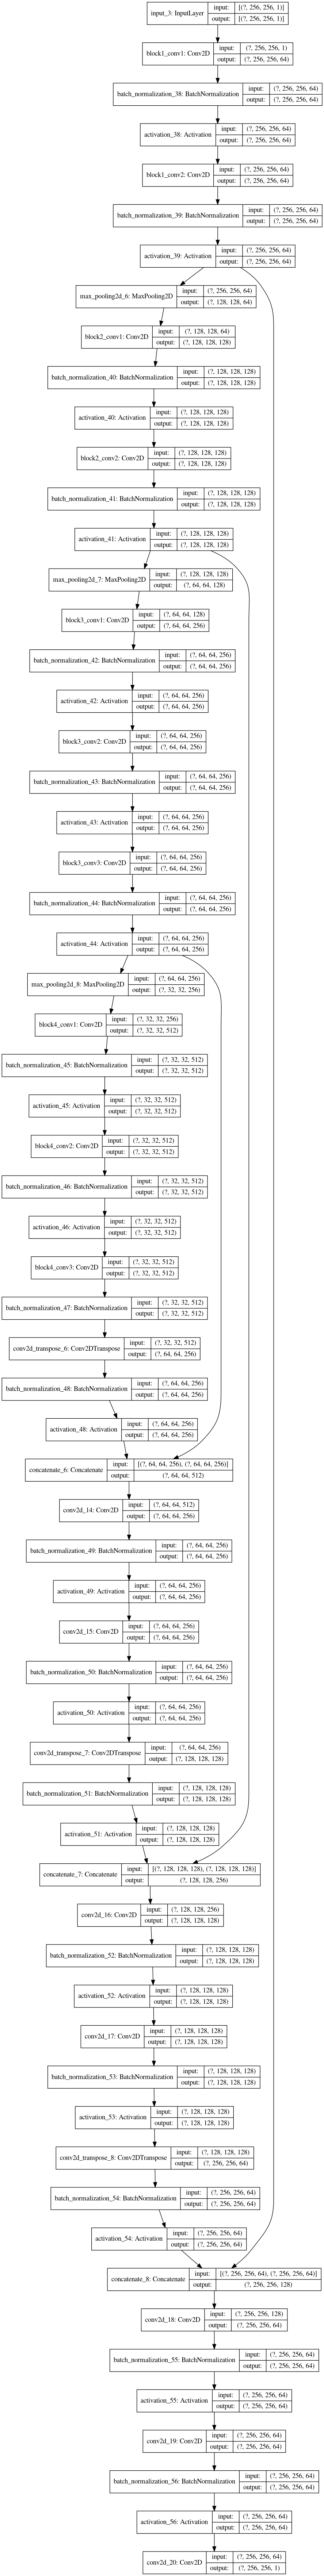

In [16]:
plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [17]:
earlystopping = EarlyStopping(monitor='loss', patience=10)
history_1 = model_1.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 30, 
                    batch_size = 16,
                    callbacks = [earlystopping])

Epoch 1/30
36/36 [==============================] - 16s 441ms/step - loss: 0.3328 - dice_coef: 0.6272 - binary_accuracy: 0.8675 - val_loss: 0.6899 - val_dice_coef: 0.3382 - val_binary_accuracy: 0.5976
Epoch 2/30
36/36 [==============================] - 14s 385ms/step - loss: 0.1401 - dice_coef: 0.8223 - binary_accuracy: 0.9595 - val_loss: 0.5771 - val_dice_coef: 0.2092 - val_binary_accuracy: 0.7453
Epoch 3/30
36/36 [==============================] - 14s 385ms/step - loss: 0.1166 - dice_coef: 0.8576 - binary_accuracy: 0.9631 - val_loss: 0.6471 - val_dice_coef: 0.1546 - val_binary_accuracy: 0.7453
Epoch 4/30
36/36 [==============================] - 14s 384ms/step - loss: 0.0948 - dice_coef: 0.8848 - binary_accuracy: 0.9694 - val_loss: 0.8075 - val_dice_coef: 0.0812 - val_binary_accuracy: 0.7454
Epoch 5/30
36/36 [==============================] - 14s 385ms/step - loss: 0.0753 - dice_coef: 0.9074 - binary_accuracy: 0.9753 - val_loss: 0.8233 - val_dice_coef: 0.0763 - val_binary_accuracy: 0.

## Качество модели

0.9707554486261007

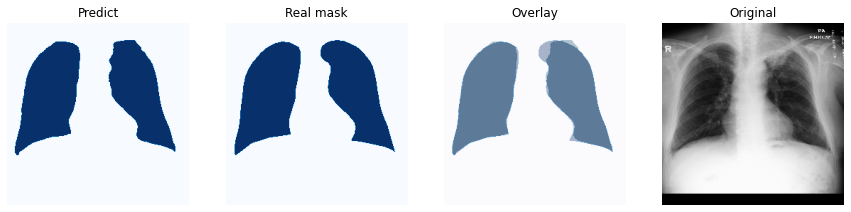

In [18]:
img_num = 1 
prediction_1 = test_on_image(model_1, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_1)

0.9116225475002294

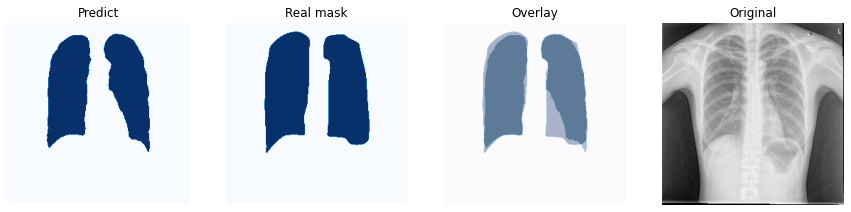

In [19]:
img_num = 3 
prediction_1 = test_on_image(model_1, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_1)

0.9779841709765915

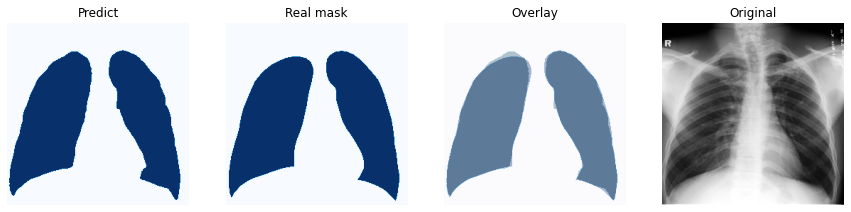

In [20]:
img_num = 5 
prediction_1 = test_on_image(model_1, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_1)

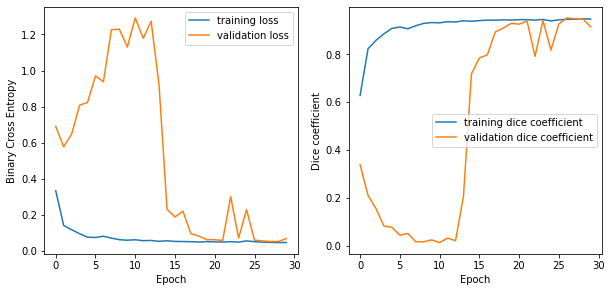

In [21]:
get_metrics(history = history_1)

100%|██████████| 141/141 [00:06<00:00, 22.96it/s]


0.6872559632217095


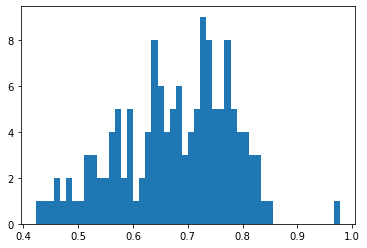

In [22]:
dice_coefs = list()
for i in tqdm(range(len(img_test))):
    prediction_2 = model_1.predict(img_test[i].reshape(1,img_side_size,256,1))
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction_1)
    dice_coefs.append(dice)

plt.hist(np.array(dice_coefs), bins = 50)
print(np.median(np.array(dice_coefs)))

**Вывод**: Качество модели удовлетворительное. Медиана дайс-коэффициента равна 0,687. модель неплохо сегментирует лёгкие.

Попробуем улучшить модель, используя другую архитектуру Unet, найденную на просторах интернета.

In [23]:
### U-net 

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
   
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [24]:
model_2 = unet(input_size=(256,256,1))
model_2.compile(optimizer=Adam(),
              loss="binary_crossentropy",
              metrics=[dice_coef, 'binary_accuracy'])
model_2.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_22[0][0]                  
_______________________________________________________________________________________

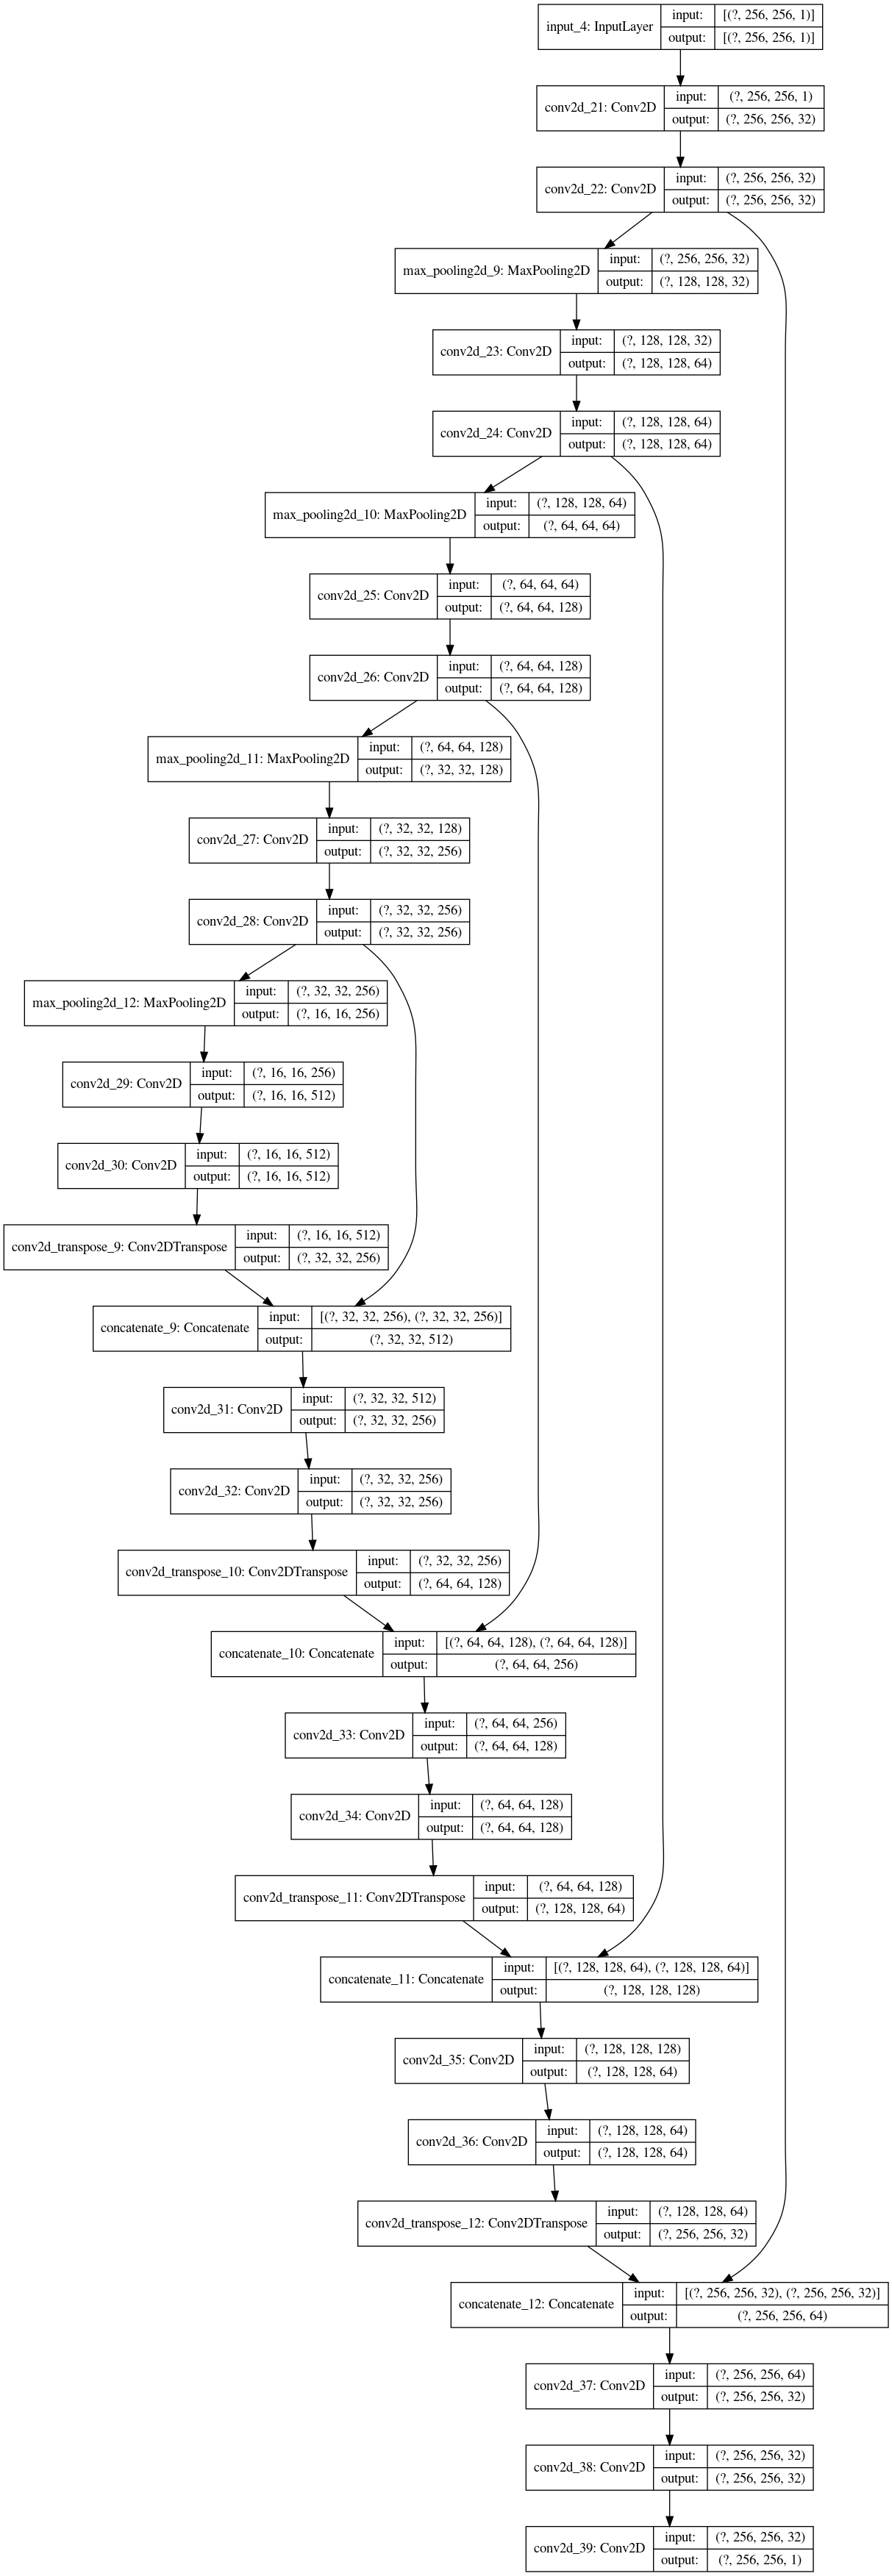

In [25]:
plot_model(model_2, to_file='model_2.png', show_shapes=True)

In [26]:
earlystopping = EarlyStopping(monitor='loss', patience=10)
history_2 = model_2.fit(x = img_train, 
                    y = mask_train, 
                    validation_data = (img_test, mask_test), 
                    epochs = 30, 
                    batch_size = 16,
                    callbacks = [earlystopping])

Epoch 1/30
36/36 [==============================] - 7s 183ms/step - loss: 0.5517 - dice_coef: 0.2885 - binary_accuracy: 0.7450 - val_loss: 0.4853 - val_dice_coef: 0.2934 - val_binary_accuracy: 0.7454
Epoch 2/30
36/36 [==============================] - 5s 140ms/step - loss: 0.4061 - dice_coef: 0.4179 - binary_accuracy: 0.7725 - val_loss: 0.3010 - val_dice_coef: 0.6367 - val_binary_accuracy: 0.8947
Epoch 3/30
36/36 [==============================] - 5s 140ms/step - loss: 0.1660 - dice_coef: 0.8034 - binary_accuracy: 0.9366 - val_loss: 0.1594 - val_dice_coef: 0.8162 - val_binary_accuracy: 0.9347
Epoch 4/30
36/36 [==============================] - 5s 140ms/step - loss: 0.1227 - dice_coef: 0.8588 - binary_accuracy: 0.9525 - val_loss: 0.1116 - val_dice_coef: 0.8799 - val_binary_accuracy: 0.9571
Epoch 5/30
36/36 [==============================] - 5s 140ms/step - loss: 0.0996 - dice_coef: 0.8864 - binary_accuracy: 0.9620 - val_loss: 0.0933 - val_dice_coef: 0.9016 - val_binary_accuracy: 0.9638


# 4. Валидация модели

0.9681753550237283

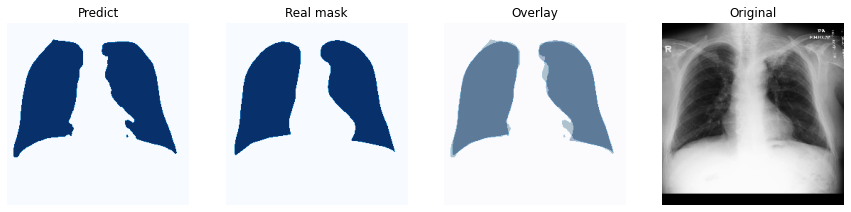

In [30]:
img_num = 1 
prediction_2 = test_on_image(model_2, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_2)

0.9145274933847493

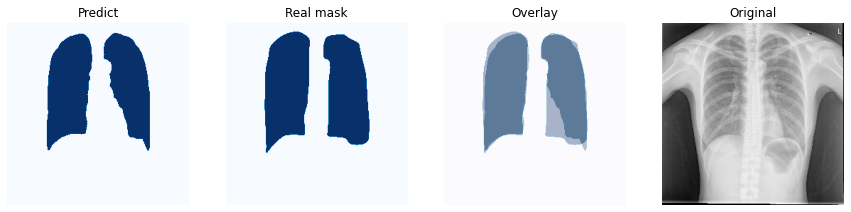

In [31]:
img_num = 3
prediction_2 = test_on_image(model_2, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_2)

0.9531751930927934

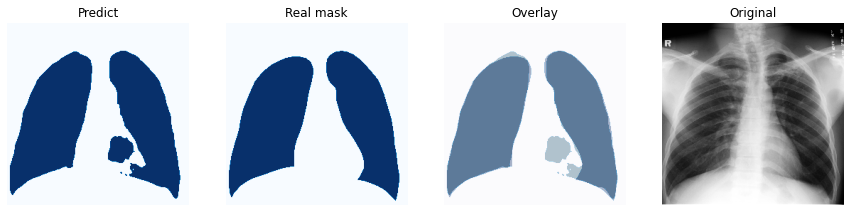

In [27]:
img_num = 5 
prediction_2 = test_on_image(model_2, img_array = img_test, img_num = img_num, img_side_size = 256)
dice_coef_test(y_true = mask_test[img_num], y_pred = prediction_2)

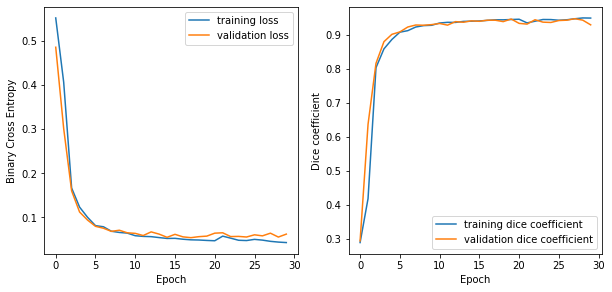

In [28]:
get_metrics(history = history_2)

Распределение Дайс коэффициентов

100%|██████████| 141/141 [00:05<00:00, 26.10it/s]


0.9347223504281638


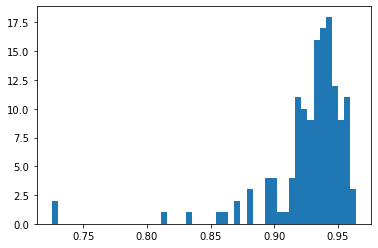

In [29]:
dice_coefs = list()
for i in tqdm(range(len(img_test))):
    prediction_2 = model_2.predict(img_test[i].reshape(1,img_side_size,256,1))
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction_2)
    dice_coefs.append(dice)

plt.hist(np.array(dice_coefs), bins = 50)
print(np.median(np.array(dice_coefs)))

# 5. Инференс модели (вывод о работе модели на тестовых объектах)

Качество второй модели значительно выше. Медиана дайс-коэффициента равна 0,935. Модель лучше сегментирует лёгкие за счёт более лучшей архитектуры.

# 6. Выводы по работе (интерпретация результатов, что можно ещё поделать, чего не хватило, планы на будущее)